<a href="https://colab.research.google.com/github/Mohamed-mosad-hadia/Skin_cancer_detection/blob/main/Skin_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'skin-cancer-malignant-vs-benign:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F174469%2F505351%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240426%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240426T030401Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D000f2a7f49abedb1d8f1639e965caf3741fac7cc360e63d8b1ec3f1cf0532a2dce945223be9a02315d3dd07d2de19b2c2ef9eadc9d80b023d3599705df1a3c55072e19c52341a91e8a271822952a7bcd834cbd37782b299fad79bc1becae6383595830508a3c764c41a6b98515827f337848545774e53bfa5f1ed85143be67de5b230349ba169a7dbfa13ea5eef67d1c9011afbbc7c05a1c1d4b852f2b14afb3175d570886bde99a7c1a456fc436a43d391884417cc14f921c5f2ebd147e4818dfa7be8eba752e877170a42e1af4e63021be86e5c53ea2df423a3aeea8b14b303b8688d616405802a6093801d610cd9cfbad24c3cd439b4731d803d6561c5752'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 340467838 bytes downloaded
Downloaded and uncompressed: skin-cancer-malignant-vs-benign
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# **import libraries**

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
import random
import cv2
import os
warnings.filterwarnings("ignore")
print(tf.__version__)

2.15.0


# **Image Preprocessing**

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_data_gen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Load and preprocess training data
training_set = train_data_gen.flow_from_directory('/kaggle/input/skin-cancer-malignant-vs-benign/train',
                                                 target_size=(64, 64),#resizes all images to a uniform size of 64x64 pixels.
                                                 batch_size=32,  #the number of images processed by the model at each training step
                                                 class_mode='binary')

# Load and preprocess test data
test_set = test_data_gen.flow_from_directory('/kaggle/input/skin-cancer-malignant-vs-benign/test',
                                            target_size=(64, 64),
                                            batch_size=32,
                                            class_mode='binary')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [ ]:
#the output = (height,width,RGB)
training_set.image_shape

(64, 64, 3)

In [ ]:
Skin_cancer_data='/kaggle/input/skin-cancer-malignant-vs-benign/train'
labels_list=os.listdir(Skin_cancer_data)
labels_list

['malignant', 'benign']

In [ ]:
images=[]
labels=[]

for i in labels_list:
    path=os.path.join(Skin_cancer_data,i)

    for img in os.listdir(path):
        image_path=os.path.join(path,img)
        images.append(image_path)
        labels.append(i)


In [ ]:
data=pd.DataFrame({"images":images,"labels":labels})
data

,images,labels
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
...,...,...
2632,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
2633,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
2634,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
2635,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign


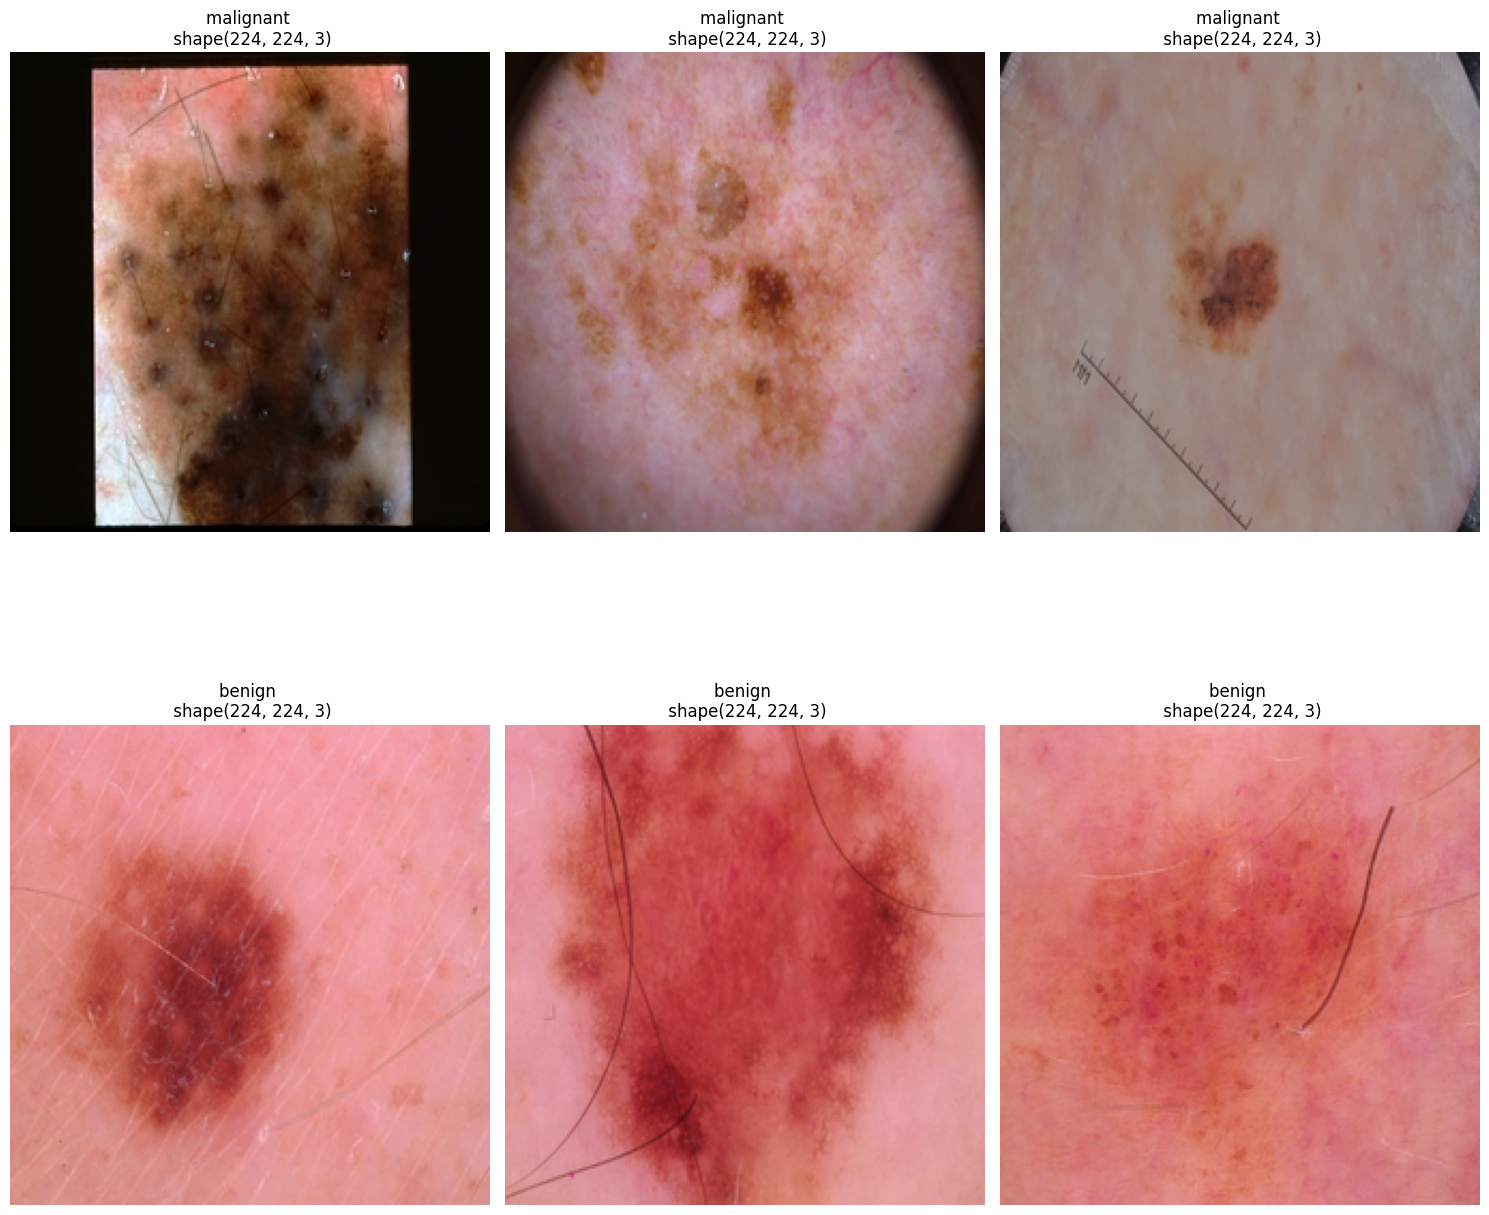

In [ ]:
fig,ax=plt.subplots(2,3,figsize=(15,15))
p=0
for label in labels_list:

    img=data["images"][data["labels"]==label]
    select_images= random.choices(img.values,k=3)

    for i,img in enumerate(select_images):
        im=cv2.imread(img)
        im_rgb=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(im_rgb)
        ax[p,i].set_title(f"{label} \n shape{im_rgb.shape}")
        ax[p,i].axis("off")

    p+=1
fig.tight_layout()
fig.show()

**Building CNN layers and full connected layers**

In [ ]:
#define CNN layers
model=Sequential()

# Convolutional layers
model.add(Convolution2D(64,(3,3),input_shape=(64,64,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#flatten layer
model.add(Flatten())

#fully connected layers
model.add(Dense(units=128,activation="relu"))#Adds a fully connected layer with 128 neurons and ReLU activation
model.add(Dense(units=1,activation='sigmoid')) # #Adds the final output layer with 1 neuron and sigmoid activation (suitable for binary classification).

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 64)         

# **Train the model**


In [ ]:
history = model.fit(training_set,
                    steps_per_epoch=32,
                    epochs=25,
                    validation_data=test_set)

Epoch 1/25
32/32 [==============================] - 5s 122ms/step - loss: 0.6103 - accuracy: 0.6388 - val_loss: 0.5932 - val_accuracy: 0.6818
Epoch 2/25
32/32 [==============================] - 5s 142ms/step - loss: 0.5370 - accuracy: 0.7324 - val_loss: 0.4699 - val_accuracy: 0.7667
Epoch 3/25
32/32 [==============================] - 4s 115ms/step - loss: 0.4684 - accuracy: 0.7656 - val_loss: 0.4830 - val_accuracy: 0.7530
Epoch 4/25
32/32 [==============================] - 4s 119ms/step - loss: 0.5201 - accuracy: 0.7334 - val_loss: 0.4504 - val_accuracy: 0.7864
Epoch 5/25
32/32 [==============================] - 4s 127ms/step - loss: 0.4585 - accuracy: 0.7851 - val_loss: 0.4822 - val_accuracy: 0.7348
Epoch 6/25
32/32 [==============================] - 4s 111ms/step - loss: 0.4374 - accuracy: 0.8037 - val_loss: 0.4337 - val_accuracy: 0.7833
Epoch 7/25
32/32 [==============================] - 4s 110ms/step - loss: 0.4647 - accuracy: 0.7881 - val_loss: 0.4539 - val_accuracy: 0.7909
Epoch 

# **Plot training history**

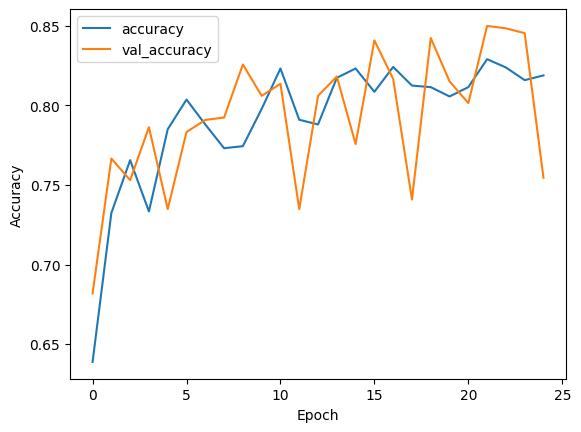

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()